In [191]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import itertools as itr
import copy
from boundaries import WallBoundary, PressureBoundary, VelocityBoundary
from generators import WallGenerators
from simulation import Simulation
import pandas as pd
import random
from openpyxl import load_workbook

In [192]:
yResolution = random.randint(20,50)
xResolution = random.randint(20,50)
ACspeed = 1

walls = WallBoundary(yResolution, xResolution)
walls.borderWall()
conditions = walls.generateRoom()
walls.generateIndex()
walls.generateACDirections()
walls.indexPossibleACPos()

bestPos = []
bestDirection = []
bestTemp = 0

[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (14, 2), (14, 3), (14, 4), (15, 5), (16, 5), (17, 5), (18, 4), (18, 3), (18, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (27, 2), (28, 3), (29, 3), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (30, 16), (30, 17), (30, 18), (30, 19), (30, 20), (30, 21), (30, 22), (30, 23), (30, 24), (30, 25), (30, 26), (30, 27), (29, 27), (28, 27), (27, 28), (27, 29), (27, 30), (27, 31), (26, 31), (25, 31), (24, 31), (23, 31), (22, 31), (21, 31), (20, 31), (19, 31), (18, 31), (17, 31), (16, 31), (15, 31), (14, 31), (13, 31), (12, 31), (11, 31), (10, 31), (9, 31), (8, 31), (7, 31), (6, 31), (5, 31), (4, 31), (3, 31), (2, 31), (1, 31), (1, 30), (1, 29), (1, 28), (1, 27), (1, 26), (1, 25), (1, 24), (1, 23), (1, 22), (1, 21), (1, 20), (1, 19), (1, 18), (1, 17), (1, 16), (1,

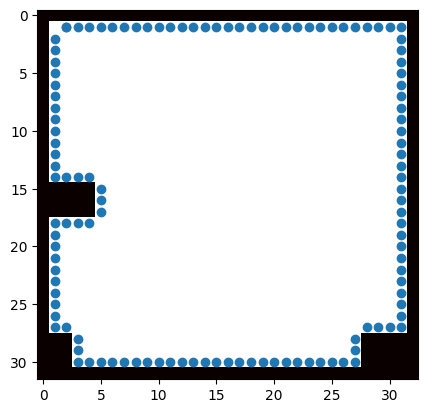

In [193]:
plt.imshow(walls.invertedBoundary, cmap="hot", interpolation="nearest")
plt.scatter([i[1] for i in walls.possibleACIndex], [i[0] for i in walls.possibleACIndex])
print(walls.possibleACIndex)

In [194]:
def sim(pos):
    for directionIndex, direction in enumerate(WallBoundary.unitVect):
        #print(f"Trying direction: {direction}...")
        pathOfFlow = [i+j for i, j in zip(pos, direction)]
        reverseFlow = [i-j for i, j in zip(pos, direction)]
        isNormal = (not walls.boundary[pathOfFlow[0], pathOfFlow[1]]) and (walls.boundary[reverseFlow[0], reverseFlow[1]])

        if (isNormal):
            velocityInlet = [VelocityBoundary(pos[0], pos[1], ACspeed, directionIndex)]
            initCondition = np.ones((yResolution, xResolution, Simulation.latticeSize)) / 9
            simulation = Simulation(
                yResolution, xResolution, initCondition, walls, velocityBoundaries=velocityInlet, pressureBoundaries=[]
            )
            simTime, stable = simulation.simulateUntilEquilibrium(equilibriumThreshold=2.5, limit = 500)
            results = simulation.getMomentum()
            #print("Done!")
            if not stable or simTime == 500:
                #print("It exploded :() or didn't equalize")
                return False, results
            else:
                return True, results

In [ ]:
learningRate = 0.5

In [196]:
currentIndex = 0
worked = False
length = len(walls.possibleACIndex)
visitedAll = np.zeros(length)
while True:
    visitedAll[currentIndex] = 1
    if (sum(visitedAll) == length):
        break
    
    currentPos = walls.possibleACIndex[currentIndex]
    print(f"Pos: {currentPos}")
    print("Simulating at pos...")
    usable, currentResults = sim(currentPos)
    if (not usable):
        print("Not stable")
        currentIndex += 1
        
    else:
        print("Stable")
        forwardPos = walls.possibleACIndex[(currentIndex + 1) % length]
        forwardUsable, forwardResults = sim(forwardPos)
        forwardDif = forwardResults - currentResults

        backwardPos = walls.possibleACIndex[(currentIndex - 1) % length] 
        backwardUsable, backwardResults = sim(backwardPos)
        backwardDif = currentResults - backwardResults

        forwardMessage = (str(forwardDif) if forwardUsable else "Unusable") 
        print(f"Forward Difference: {forwardMessage}")

        backwardMessage = (str(backwardDif) if backwardUsable else "Unusable") 
        print(f"Backward Difference: {backwardMessage}")

        if ((forwardDif < 0 and forwardUsable) and (backwardDif > 0 and backwardUsable)):
            print("Reached Equil.")
            worked = True
            break
        else:
            gradient = (forwardDif * forwardUsable) + (backwardDif * backwardUsable)
            print(f"Gradient: {gradient}")
            indexMove = learningRate * gradient
            if (indexMove < 1):
                print("Gradient too small. Pushing...")
                indexMove = np.sign(indexMove)
            
            currentIndex = (currentIndex + int(indexMove)) % length
    
    print("------------")

if (not worked):
    print("Didn't work.")
else:   
    print(f"Worked! {walls.possibleACIndex[currentIndex]}")


Pos: (2, 1)
Simulating at pos...
Stable
Forward Difference: 0.9240177848798865
Backward Difference: 6.384079834908322
Gradient: 7.308097619788208
------------
Pos: (9, 1)
Simulating at pos...
Stable
Forward Difference: -0.13759136754276735
Backward Difference: -0.32898462612148904
Gradient: -0.4665759936642564
Gradient too small. Pushing...
------------
Pos: (8, 1)
Simulating at pos...
Stable
Forward Difference: -0.32898462612148904
Backward Difference: -0.32679855667549074
Gradient: -0.6557831827969798
Gradient too small. Pushing...
------------
Pos: (7, 1)
Simulating at pos...
Stable
Forward Difference: -0.32679855667549074
Backward Difference: -0.20496408253807807
Gradient: -0.5317626392135688
Gradient too small. Pushing...
------------
Pos: (6, 1)
Simulating at pos...
Stable
Forward Difference: -0.20496408253807807
Backward Difference: -0.07475566268872225
Gradient: -0.2797197452268003
Gradient too small. Pushing...
------------
Pos: (5, 1)
Simulating at pos...
Stable
Forward Diffe